# Supervised Learning Final Project

## Income Prediction Based on Census Data

A Binary Classification Task (Income Prediction >$50K or <=$50K per year) tackled using multiple Supervised Learning Algorithms including but not limited to SVM, GradientBoosting and Random Forests

The purpose of the task is to be able to find which features mostly affect net income and can subsequntly be used by governments to help with optimizing resource allocation in an attempt to improve living standards

In [1]:
# Import libraries

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# About the data
The data is a UC Irvine Machine Learning Repository dataset consisting of 14 Features, 1 Target, with 48842 records
It was extracted by Barry Becker from the 1994 Census deatabase

Kohavi,Ron. (1996). Census Income. UCI Machine Learning Repository. https://doi.org/10.24432/C5GP7S.

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 
  
# metadata 
# print(census_income.metadata) 
  
# variable information 
print(census_income.variables) 


              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

## Data Cleaning and EDA

Since the data is large, we can get rid of records with missing values as they don't form a significant portion of the dataset

In [3]:
# Drop missing values

X.dropna(inplace=True)
X.drop_duplicates(inplace=True)
X = X[X != '?'].dropna()
y = y.loc[X.index]
y.dropna(inplace=True)
X = X.loc[y.index]

X.shape

(45170, 14)

Categorical features are converted to integer to simplify analysis

In some records, there is a period after the value, so the values are mapped to what they would've been without the period

In [4]:
# Convert categorical features to numerical

categorical_features_X = X.select_dtypes(include='object').columns.tolist()
unique_values = [X[feature].unique() for feature in categorical_features_X]

for i, feature in enumerate(categorical_features_X):
    X[feature] = X[feature].map({value: j for j, value in enumerate(unique_values[i])})

print("Categories in y: ", y['income'].unique())

y['income'] = y['income'].map({'<=50K.': 0, '<=50K': 0, '>50K': 1, '>50K.': 1})

print("\nCategories in each categorical feature:")

for feature, values in zip (categorical_features_X, unique_values):
    print(f"{feature}: {values}")

Categories in y:  ['<=50K' '>50K' '<=50K.' '>50K.']

Categories in each categorical feature:
workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']
education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 '7th-8th' 'Doctorate' 'Assoc-voc' 'Prof-school' '5th-6th' '10th'
 'Preschool' '12th' '1st-4th']
marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Craft-repair' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']
relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex: ['Male' 'Female']
native-country: ['United-States' 'Cuba' 'Jamai

A box-plot and histogram of the data is plotted to visualize how the distribution of data is to figure out how the data can be further cleaned

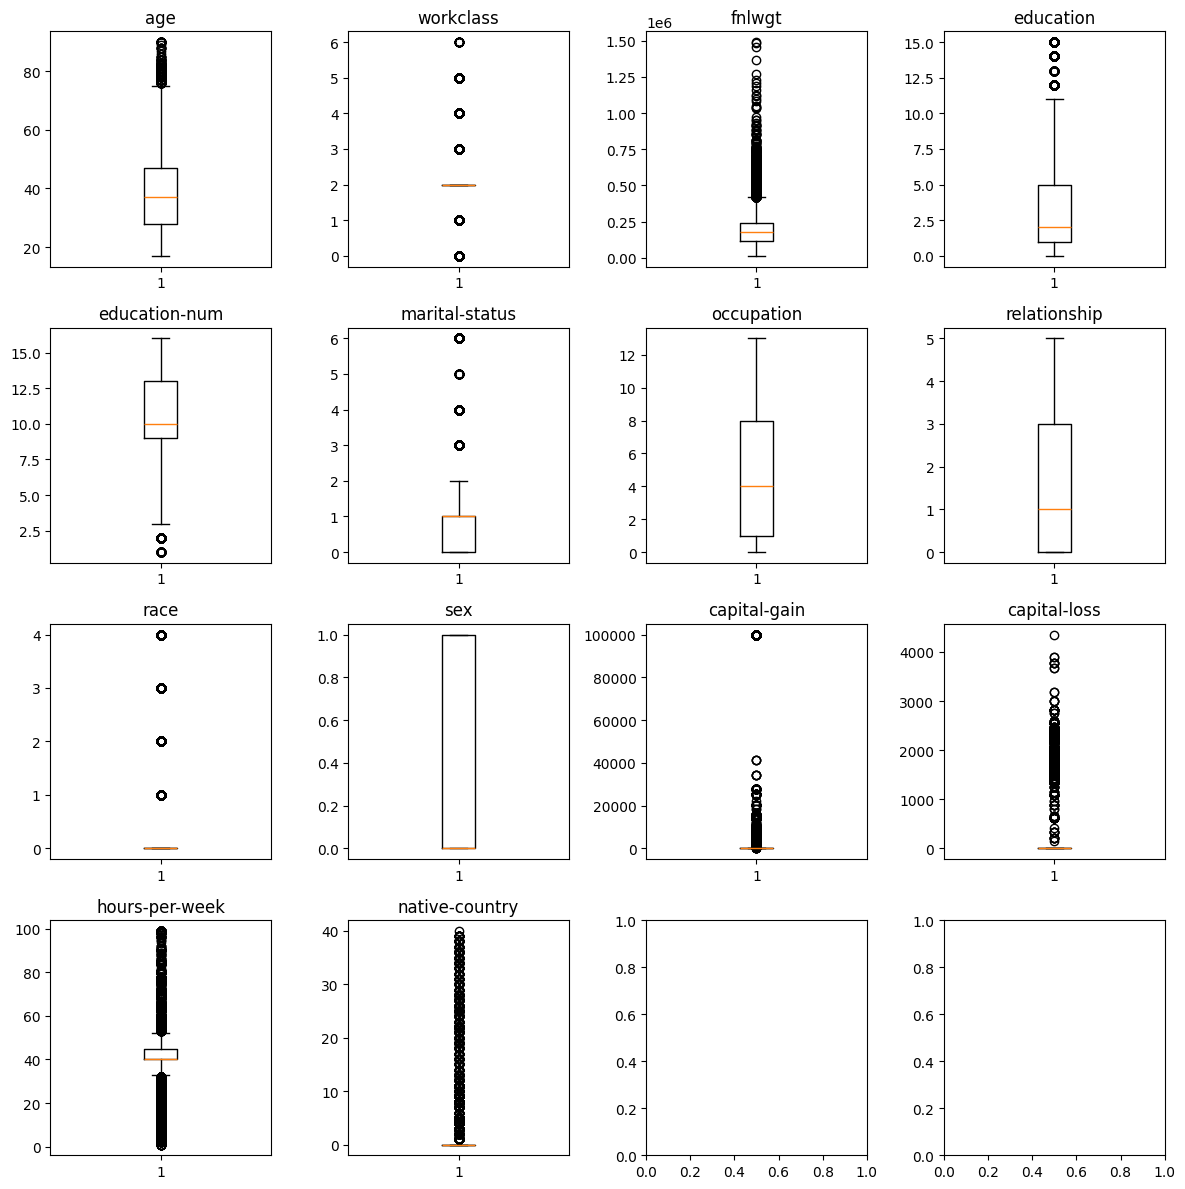

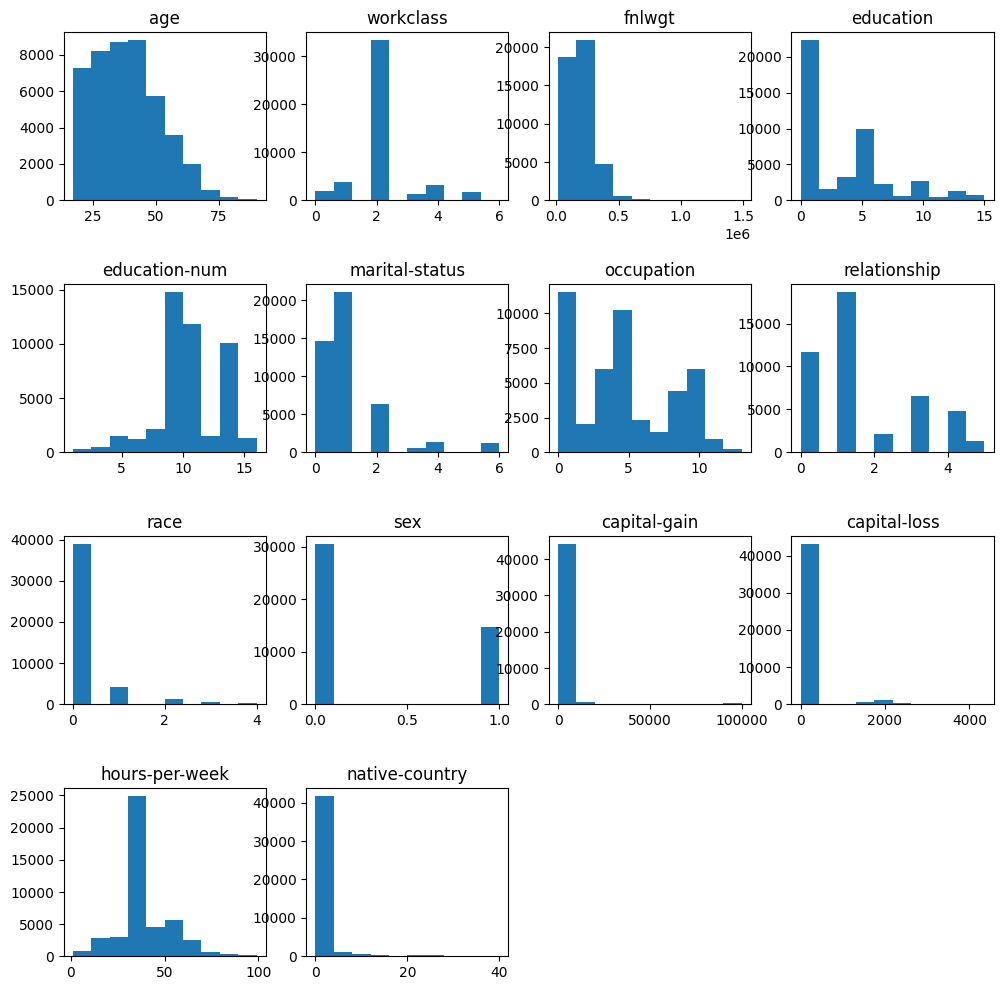

In [5]:
# Boxplot and histogram

def plot_box(X, y):
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Iterate over each feature and plot the boxplot
    for i, feature in enumerate(X.columns):
        ax = axes[i]
        ax.boxplot(X[feature])
        ax.set_title(feature)
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
def plot_hist(X,y):
    # Define the number of bins for the histograms
    num_bins = 10
    
    # Create subplots for each variable
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5)
    
    # Iterate over each variable and plot the mini histogram
    for i, var_name in enumerate(X.columns):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        ax.hist(X[var_name], bins=num_bins)
        ax.set_title(var_name)
    
    # Remove empty subplots
    if i < 15:
        for j in range(i+1, 16):
            row = j // 4
            col = j % 4
            fig.delaxes(axes[row, col])
    
    # Show the plot
    plt.show()
plot_box(X,y)
plot_hist(X,y)

There seem to be some outliers (more than 3 standard deviations away from the mean) in the data, which may affect the generalization of the models, so outliers are removed

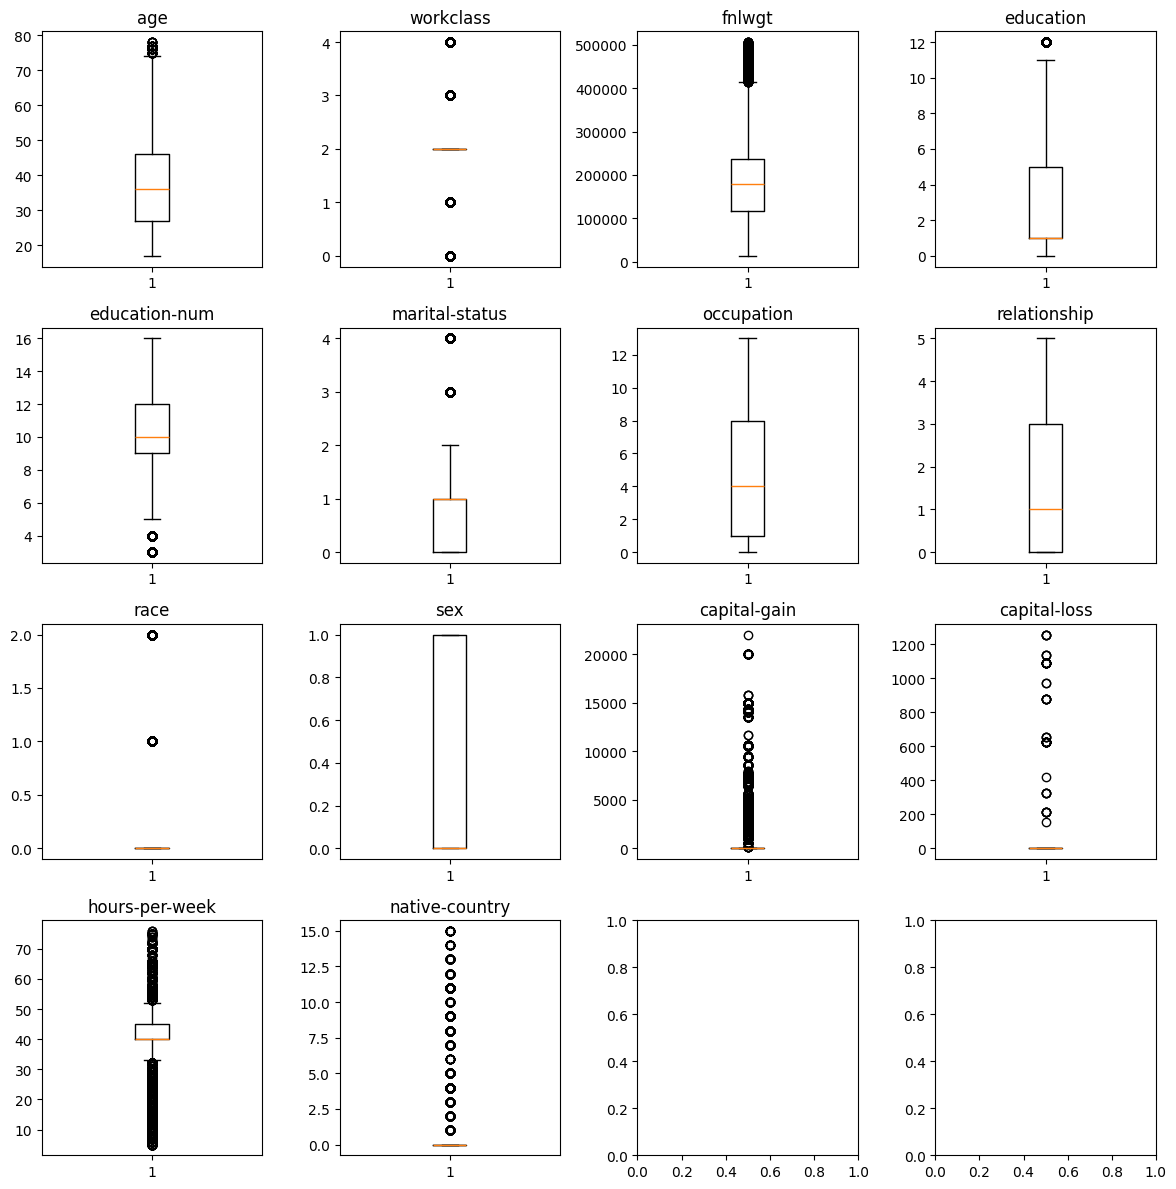

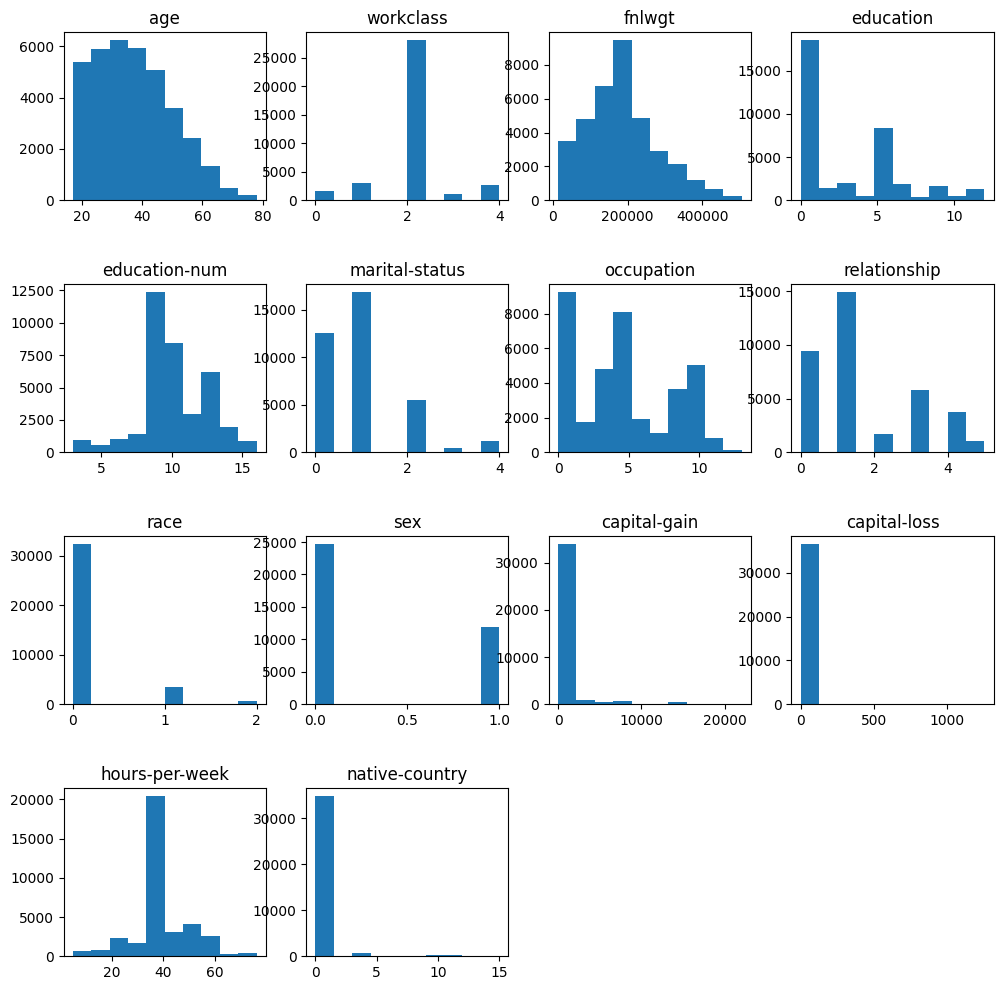

In [6]:
import numpy as np
from scipy import stats

# Remove outliers using z-scores

# Calculate z-scores for each feature
z_scores = np.abs(stats.zscore(X))

# Define a threshold for outlier detection
threshold = 3

# Remove outliers for each feature
X = X[(z_scores < threshold).all(axis=1)]
y = y.loc[X.index]

plot_box(X,y)
plot_hist(X,y)

The features "native-country", "race", "capital-gain" and "Capital Loss" have too much of the data skewed to one category, so the scope of the task is narrowed by removing the records with data corresponding to minimally recorded catogries.

The problem with this will be discussed in the analysis later

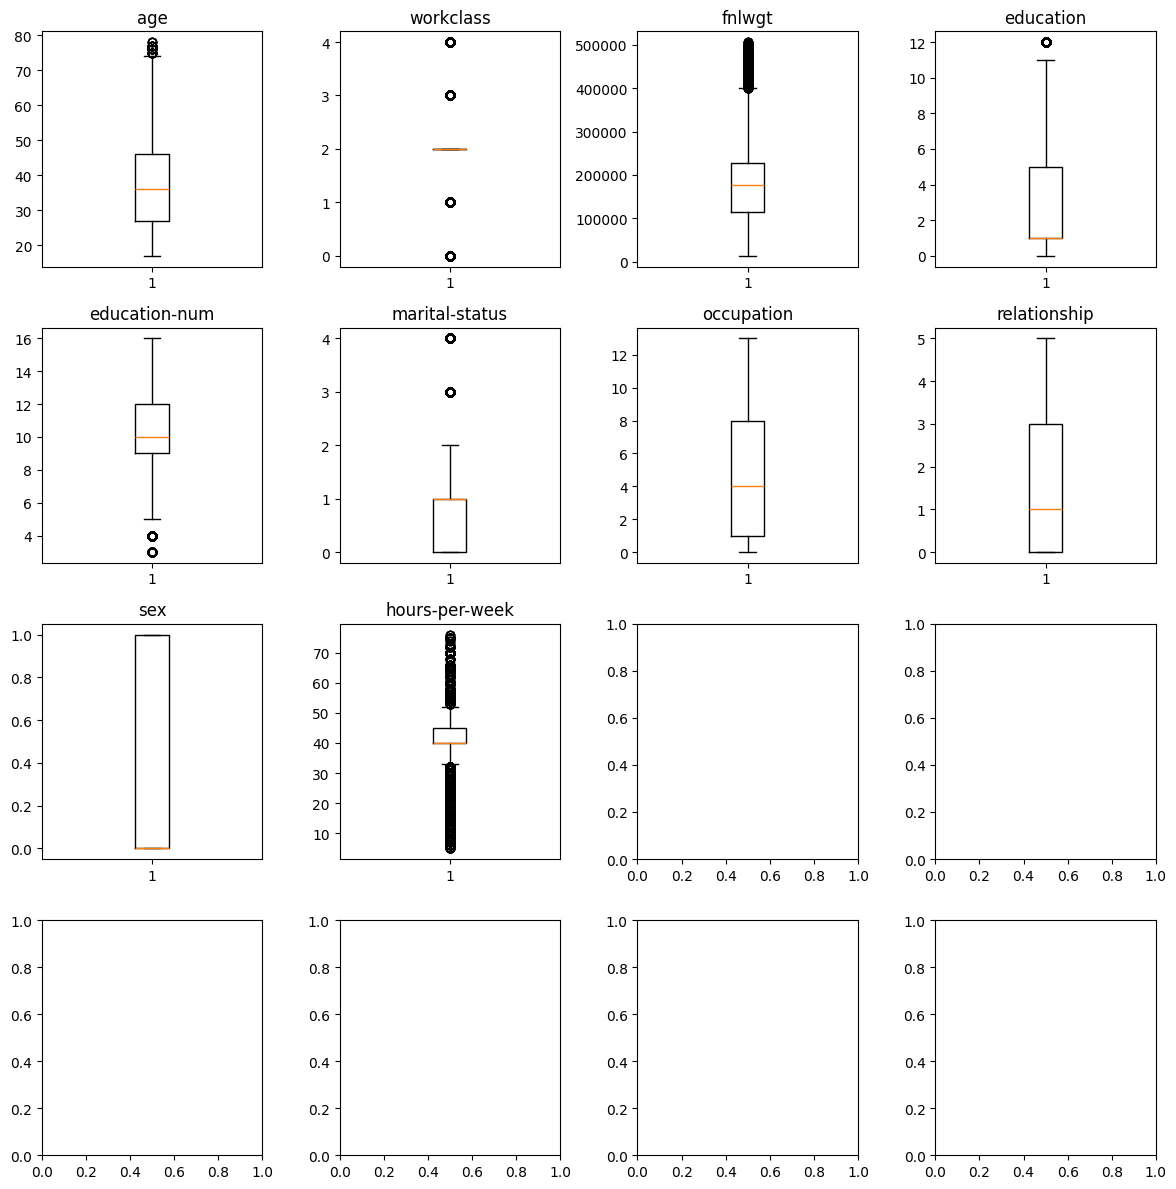

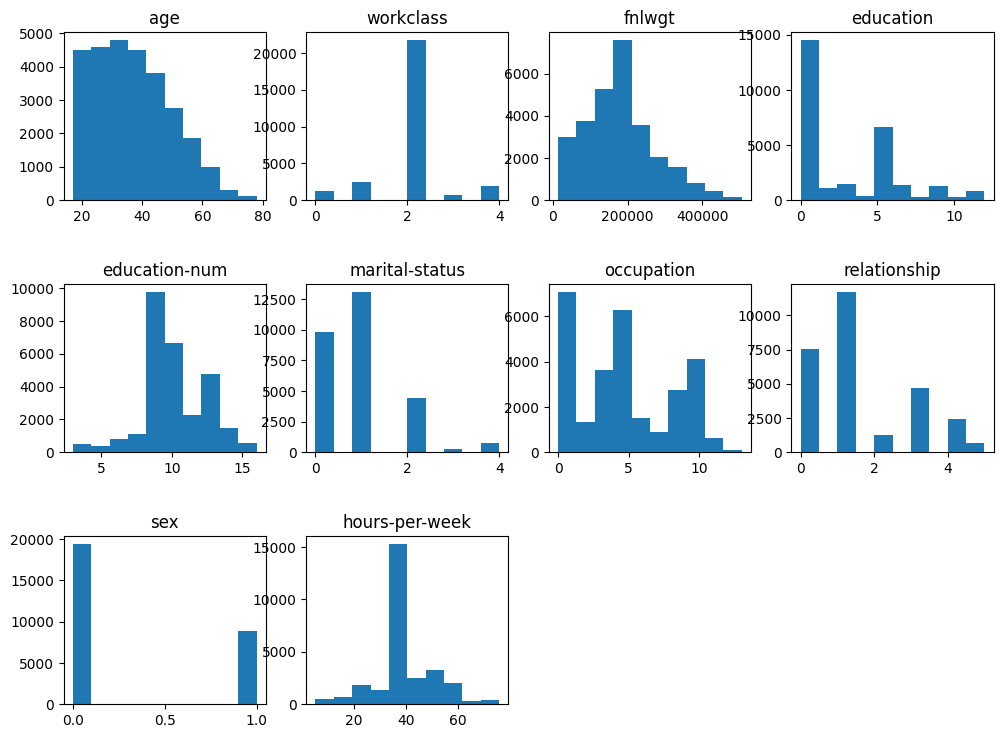

In [7]:
# Drop features with low variance

X = X[X['native-country'] == 0]
X = X[X['race'] == 0]
X = X[X['capital-gain'] == 0]
X = X[X['capital-loss'] == 0]
y = y.loc[X.index]

X = X.drop(['capital-gain', 'capital-loss', 'native-country', 'race'], axis=1)
plot_box(X,y)
plot_hist(X,y)

The size of the data is now significantly reduced, but the scope of the problem has also been narrowed, so it should not deviate much from the updated task.

In [8]:
print(X.shape)

(28245, 10)


A heatmap corresponding to the correlation matrix is plotted.
There is only weak correleation (|r| < 2.5) between features, so it doesn not have to be addressed

<Axes: >

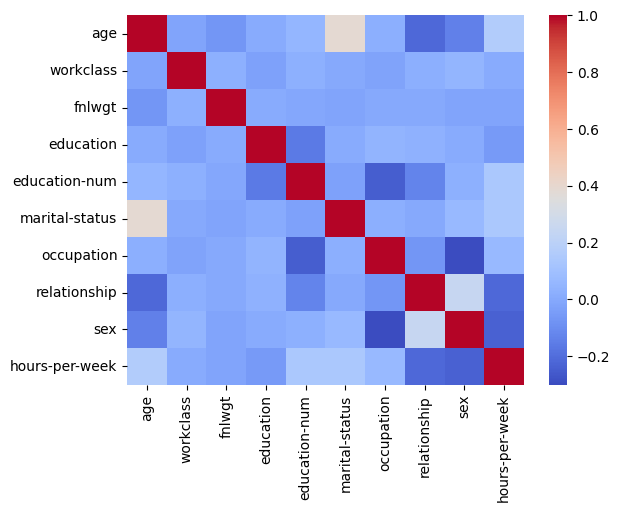

In [9]:
# Plot correlation matrix using seaborn

sns.heatmap(X.corr(), cmap='coolwarm')

# Models

First, the data is split into a training and testing set in a 4:1 ratio

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM Classifier (RBF Kernel)

First, we scale the features as SVMs are very sensitive to the scale of features

We iterate over different values for gamma and C (2<sup>-4</sup> to 2<sup>4</sup>) to find the optimal parameters.
A heatmap representing the validation score of each model is plotted

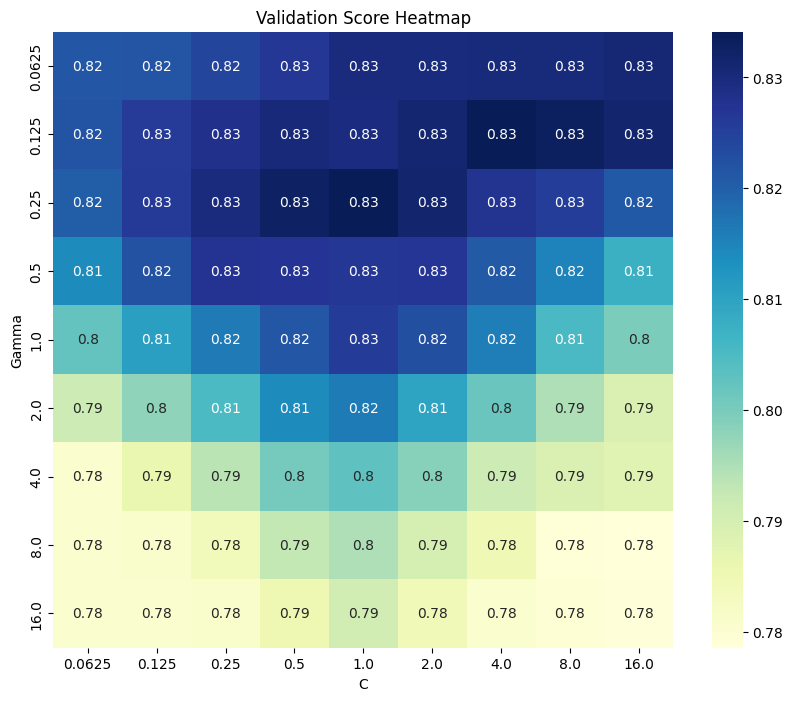

Best Parameters:  gamma =  0.125 C =  4.0
Training Score:  0.8509028146574615
Validation Score:  0.8341299345016817


In [11]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Iterate over different hyperparameters for the SVC model
svc_scores = []
for gamma in [2**i for i in range(-4, 5)]:
    for C in [2**i for i in range(-4, 5)]:
        svc = SVC(kernel='rbf', gamma=gamma, C=C, random_state=42).fit(X_train_scaled, y_train)
        svc_scores.append({
            "gamma": gamma,
            "C": C,
            "training_score": svc.score(X_train_scaled, y_train),
            "validation_score": svc.score(X_test_scaled, y_test)
        })
        
# Find the best hyperparameters from the scores
svc_best_params = pd.DataFrame(svc_scores).sort_values(by='validation_score', ascending=False).iloc[0]
svc_best = SVC(kernel='rbf', gamma=svc_best_params['gamma'], C=svc_best_params['C']).fit(X_train_scaled, y_train)

svc_scores = pd.DataFrame(svc_scores)
pivot_table = svc_scores.pivot(index="gamma", columns="C", values="validation_score")

# Create a pivot table from the scores DataFrame
pivot_table = svc_scores.pivot(index='gamma', columns='C', values='validation_score')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Score Heatmap')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()
# Print the best hyperparameters and scores
print("Best Parameters: ", "gamma = ", svc_best_params['gamma'], "C = ", svc_best_params['C'])
print("Training Score: ", svc_best.score(X_train_scaled, y_train))
print("Validation Score: ", svc_best.score(X_test_scaled, y_test))

#### Additional Metrics on model with best parameters

In [12]:
print("Metrics")
y_pred = svc_best.predict(X_test_scaled)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Metrics
Precision:  0.6864197530864198
Recall:  0.4487489911218725
F1 Score:  0.5427037579306979
ROC AUC Score:  0.6955763096198931


### Decision Tree

First, we make a Decision Tree with the default parameters and see how it performs

In [13]:
# Decision Tree
decision_tree = DecisionTreeClassifier(ccp_alpha=0,random_state=42).fit(X_train, y_train)
print("Decision Tree")
print("Training Score: ", decision_tree.score(X_train, y_train))
print("Validation Score: ", decision_tree.score(X_test, y_test))

Decision Tree
Training Score:  1.0
Validation Score:  0.7774827403080191


The Training Score for default Decision Tree is 1, with a significantly lower Validation Score. This is indicative of overfitting. To test this and optimize the model, ccp_alpha is tuned to find the optimal pruning.

This ccp_alpha will be used while attempting to optimize the model using ensembles.

The impoortances of each feature in the Decision Tree are shown

Optimal ccp_alpha:  0.00018181818181818183
Training Score:  0.8420516905647017
Validation Score:  0.8327137546468402

Feature Importances
marital-status: 0.504528799843126
education-num: 0.30929915839861477
age: 0.0706952736382301
occupation: 0.03694183580500633
hours-per-week: 0.03478212572514617
education: 0.01955766629365337
workclass: 0.01576827148600302
fnlwgt: 0.005837087200232617
relationship: 0.0025897816099877164
sex: 0.0


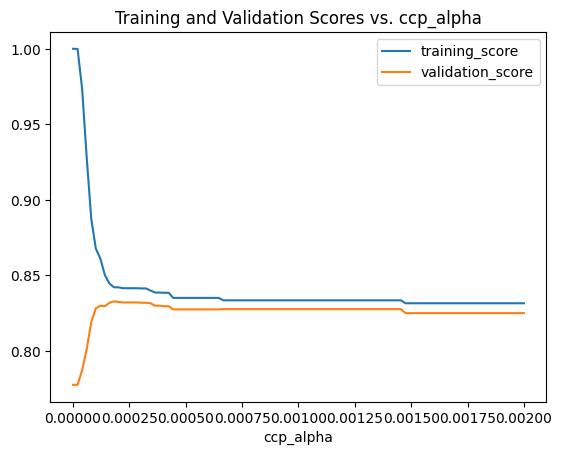

In [14]:
# Iterate over values for ccp_alpha
ccp_alpha_scores = []
for ccp_alpha in np.linspace(0, 0.002, 100):
    decision_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=42).fit(X_train, y_train)
    ccp_alpha_scores.append({
        "ccp_alpha": ccp_alpha,
        "training_score": decision_tree.score(X_train, y_train),
        "validation_score": decision_tree.score(X_test, y_test)
    })
# Find the best ccp_alpha from the scores
ccp_alpha_scores = pd.DataFrame(ccp_alpha_scores)
ccp_alpha_scores.plot(x='ccp_alpha', y=['training_score', 'validation_score'], title='Training and Validation Scores vs. ccp_alpha')
print("Optimal ccp_alpha: ", ccp_alpha_scores.sort_values(by='validation_score', ascending=False).iloc[0]['ccp_alpha'])
print("Training Score: ", ccp_alpha_scores.sort_values(by='validation_score', ascending=False).iloc[0]['training_score'])
print("Validation Score: ", ccp_alpha_scores.sort_values(by='validation_score', ascending=False).iloc[0]['validation_score'])

ccp_optimal = ccp_alpha_scores.sort_values(by='validation_score', ascending=False).iloc[0]['ccp_alpha']

decision_tree_best = DecisionTreeClassifier(ccp_alpha=ccp_optimal, random_state=42).fit(X_train, y_train)
# Print the important features
print("\nFeature Importances")
feature_importances = pd.Series(decision_tree_best.feature_importances_, index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

As the plot shows, without pruning, the model overfits the data, lowering the validation score.
The optimal amount of pruning should vary with the number of estimators and max depth, but this is not considered to avoid complexity

### Random Forest

First, we iterate over the number of estimators from 10 to 300 and plot the corresponding training and validation scores

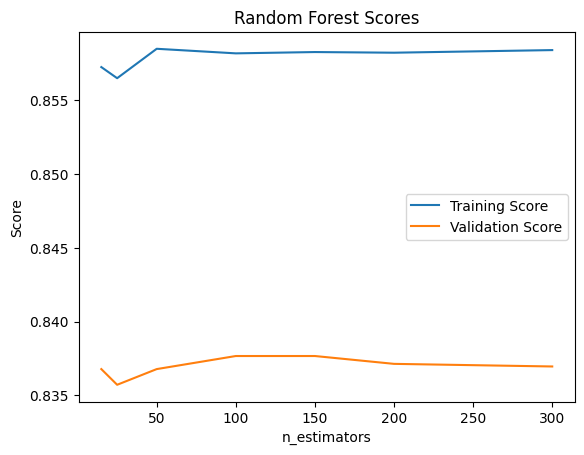

n_estimators:  100.0
Training Score:  0.8581607364135245
Validation Score:  0.8376703841387856


In [15]:
rf_scores_estimators = []
for n_estimators in [15, 25, 50, 100, 150, 200, 300]:
    random_forest = RandomForestClassifier(n_estimators=n_estimators, random_state=42, ccp_alpha=ccp_optimal).fit(X_train, y_train)
    rf_scores_estimators.append({
        "n_estimators": n_estimators,
        "training_score": random_forest.score(X_train, y_train),
        "validation_score": random_forest.score(X_test, y_test)
    })

rf_estimators_best_params = pd.DataFrame(rf_scores_estimators).sort_values(by='validation_score', ascending=False).iloc[0]

rf_scores_estimators = pd.DataFrame(rf_scores_estimators)
plt.plot(rf_scores_estimators['n_estimators'], rf_scores_estimators['training_score'], label='Training Score')
plt.plot(rf_scores_estimators['n_estimators'], rf_scores_estimators['validation_score'], label='Validation Score')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Random Forest Scores')
plt.legend()
plt.show()
print("n_estimators: ", rf_estimators_best_params['n_estimators'])
print("Training Score: ", rf_estimators_best_params['training_score'])
print("Validation Score: ", rf_estimators_best_params['validation_score'])

Max Depth for each base estimator is then tuned to further optimize the hyperparameters.

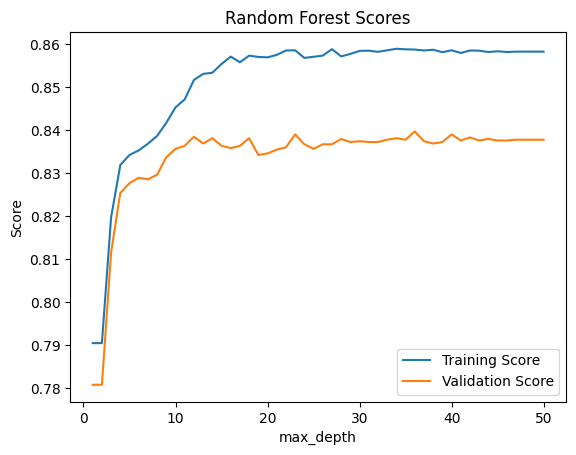

Best Params
{'n_estimators': 100, 'max_depth': 36}
Training accuracy:  0.8586475482386263
Validation accuracy:  0.8396176314391928


In [16]:
rf_scores_depth = []
for max_depth in range(1, 51):
    random_forest = RandomForestClassifier(n_estimators=int(rf_estimators_best_params['n_estimators']), ccp_alpha=ccp_optimal, max_depth=max_depth, random_state=42).fit(X_train, y_train)
    rf_scores_depth.append({
        "max_depth": max_depth,
        "training_score": random_forest.score(X_train, y_train),
        "validation_score": random_forest.score(X_test, y_test)
    })

rf_depth_best_params = pd.DataFrame(rf_scores_depth).sort_values(by='validation_score', ascending=False).iloc[0]
rf_best_params = {"n_estimators": int(rf_estimators_best_params['n_estimators']), "max_depth": int(rf_depth_best_params['max_depth'])}

rf_scores_depth = pd.DataFrame(rf_scores_depth)
plt.plot(rf_scores_depth['max_depth'], rf_scores_depth['training_score'], label='Training Score')
plt.plot(rf_scores_depth['max_depth'], rf_scores_depth['validation_score'], label='Validation Score')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.title('Random Forest Scores')
plt.legend()
plt.show()
rf_best = RandomForestClassifier(n_estimators=rf_best_params['n_estimators'], ccp_alpha=ccp_optimal, max_depth=rf_best_params['max_depth'], random_state=42).fit(X_train, y_train)
print("Best Params")
print(rf_best_params)
print("Training accuracy: ", rf_best.score(X_train, y_train))
print("Validation accuracy: ", rf_best.score(X_test, y_test))

Above a max depth of about 15, the performance of the model is pretty much constant, with slight variations.

#### Additional Metrics on model with optimal hyperparameters

Importance of each feature in the predictions using a Random Forest Ensemble is shown

In [17]:
print("Metrics")
y_pred = rf_best.predict(X_test)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

print("\nFeature Importances")
feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Metrics
Precision:  0.6998799519807923
Recall:  0.4705407586763519
F1 Score:  0.5627413127413128
ROC AUC Score:  0.7069257081363619

Feature Importances
marital-status: 0.23889505376500755
education-num: 0.19153505466108708
relationship: 0.17690470111095571
age: 0.14071805441248658
occupation: 0.06438309366644747
hours-per-week: 0.05923154518115879
fnlwgt: 0.045405684581506116
education: 0.03997384027160949
sex: 0.02335604878785468
workclass: 0.019596923561886626


### Gradient Boosting

First, we iterate over number of estimators from 10 to 500 to find the optimal number of estimators

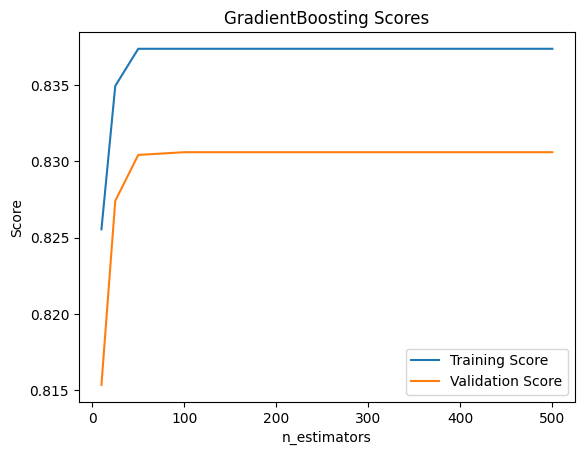

Best n_estimators:
n_estimators:  100.0
Training Score:  0.837360594795539
Validation Score:  0.8305894848645778


In [18]:
gb_scores_estimators = []
for n_estimators in [10, 25, 50, 100, 150, 200, 300, 500]:
    gb_boost = GradientBoostingClassifier(n_estimators=n_estimators, ccp_alpha=ccp_optimal, random_state=42).fit(X_train, y_train)
    gb_scores_estimators.append({
        "n_estimators": n_estimators,
        "training_score": gb_boost.score(X_train, y_train),
        "validation_score": gb_boost.score(X_test, y_test)
    })

gb_estimators_best_params = pd.DataFrame(gb_scores_estimators).sort_values(by='validation_score', ascending=False).iloc[0]

gb_scores_estimators = pd.DataFrame(gb_scores_estimators)
plt.plot(gb_scores_estimators['n_estimators'], gb_scores_estimators['training_score'], label='Training Score')
plt.plot(gb_scores_estimators['n_estimators'], gb_scores_estimators['validation_score'], label='Validation Score')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('GradientBoosting Scores')
plt.legend()
plt.show()
print("Best n_estimators:")
print("n_estimators: ", gb_estimators_best_params['n_estimators'])
print("Training Score: ", gb_estimators_best_params['training_score'])
print("Validation Score: ", gb_estimators_best_params['validation_score'])

Above approximately 50 estimators, the performance of the model becomes constant as number of estimators increases

Max depth for each base estimater is tuned to further optimize hyperparameters

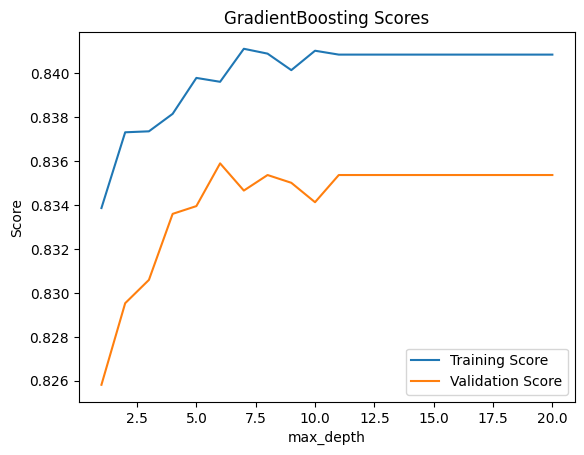

Best Params:
{'n_estimators': 100.0, 'max_depth': 6}
Training accuracy:  0.8396176314391928
Validation accuracy:  0.8359001593202336


In [19]:
gb_scores_depth = []
for max_depth in range(1, 21):
    gb_boost = GradientBoostingClassifier(n_estimators=int(gb_estimators_best_params['n_estimators']), ccp_alpha=ccp_optimal, max_depth=max_depth, random_state=42).fit(X_train, y_train)
    gb_scores_depth.append({
        "max_depth": max_depth,
        "training_score": gb_boost.score(X_train, y_train),
        "validation_score": gb_boost.score(X_test, y_test)
    })

gb_depth_best_params = pd.DataFrame(gb_scores_depth).sort_values(by='validation_score', ascending=False).iloc[0]
gb_best_params = {"n_estimators": gb_estimators_best_params['n_estimators'], "max_depth": int(gb_depth_best_params['max_depth'])}

gb_score = pd.DataFrame(gb_scores_depth)
plt.plot(gb_score['max_depth'], gb_score['training_score'], label='Training Score')
plt.plot(gb_score['max_depth'], gb_score['validation_score'], label='Validation Score')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.title('GradientBoosting Scores')
plt.legend()
plt.show()
gb_best = GradientBoostingClassifier(n_estimators=int(gb_best_params['n_estimators']), ccp_alpha=ccp_optimal, max_depth=gb_best_params['max_depth'], random_state=42).fit(X_train, y_train)
print("Best Params:")
print(gb_best_params)
print("Training accuracy: ", gb_best.score(X_train, y_train))
print("Validation accuracy: ", gb_best.score(X_test, y_test))



Once the max depth goes above 10, the score of the model is constant with an increase in max depth.

#### Additional Metrics on model with optimal hyperparameters

The importances of relevant features are shown bewlow

In [20]:
print("Metrics")
y_pred = gb_best.predict(X_test)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

print("\nFeature Importances")
feature_importances = pd.Series(gb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Metrics
Precision:  0.7160664819944599
Recall:  0.41727199354318
F1 Score:  0.5272819989801122
ROC AUC Score:  0.6853933663861026

Feature Importances
marital-status: 0.44996341078246843
education-num: 0.3040686231077494
age: 0.09242255183800947
hours-per-week: 0.047631614439719736
relationship: 0.042393619348772345
occupation: 0.038541739422807475
workclass: 0.010650391269507673
education: 0.0065783610141820475
fnlwgt: 0.005959920453310524
sex: 0.0017897683234729257


## Additional Models

### Logistic Regression

In [21]:
logistic_regression = LogisticRegression(random_state=42).fit(X_train, y_train)
print("Logistic Regression")
print("Training Score: ", logistic_regression.score(X_train, y_train))
print("Validation Score: ", logistic_regression.score(X_test, y_test))

Logistic Regression
Training Score:  0.787617277394229
Validation Score:  0.7771286953443087


#### Additional Metrics

In [22]:
print("Metrics")
y_pred = logistic_regression.predict(X_test)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

print("\nFeature Importances")
feature_importances = pd.Series(np.abs(logistic_regression.coef_[0]), index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Metrics
Precision:  0.2222222222222222
Recall:  0.00645682001614205
F1 Score:  0.012549019607843137
ROC AUC Score:  0.5000538068334679

Feature Importances
occupation: 0.12492619563231966
relationship: 0.08458842860084616
education: 0.08296788742866996
sex: 0.03384364763839042
workclass: 0.032930360732877716
education-num: 0.020254570114309072
age: 0.015346827443950257
hours-per-week: 0.0026519382856071143
marital-status: 0.0010194897860026082
fnlwgt: 2.6661168725474543e-06


### Gaussian Naive-Baye's

In [23]:
gaussian_nb = GaussianNB().fit(X_train, y_train)
print("Gaussian Naive Bayes")
print("Training Score: ", gaussian_nb.score(X_train, y_train))
print("Validation Score: ", gaussian_nb.score(X_test, y_test))

Gaussian Naive Bayes
Training Score:  0.8035050451407328
Validation Score:  0.7932377411931315


#### Additional Metrics

In [24]:
print("Metrics")
y_pred = gaussian_nb.predict(X_test)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

print("\nFeature Importances")
feature_importances = pd.Series(gaussian_nb.theta_[0], index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Metrics
Precision:  0.6414342629482072
Recall:  0.12994350282485875
F1 Score:  0.21610738255033557
ROC AUC Score:  0.5547676697797763

Feature Importances
fnlwgt: 181427.20762640686
hours-per-week: 39.31591914440898
age: 35.51503443641861
education-num: 9.868021725740522
occupation: 4.7856542919536365
education: 3.142225208578308
workclass: 1.9726188476398454
relationship: 1.553558429923288
marital-status: 0.8677417548574948
sex: 0.3613864158127555


### Multi-Layer Perceptron
The model is regularized to optimize performance.

In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam',
                    alpha=0.0001, random_state=42).fit(X_train_scaled, y_train)
print("MLP")
print("Training Score: ", mlp.score(X_train_scaled, y_train))
print("Validation Score: ", mlp.score(X_test_scaled, y_test))

MLP
Training Score:  0.8905115949725615
Validation Score:  0.820853248362542


#### Additional Metrics

In [26]:
print("Metrics")
y_pred = mlp.predict(X_test_scaled)
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

print("\nFeature Importances")
feature_importances = pd.Series(np.abs(mlp.coefs_[0].mean(axis=1)), index=X.columns).sort_values(ascending=False)
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance}")

Metrics
Precision:  0.6154628687690743
Recall:  0.4882970137207425
F1 Score:  0.5445544554455446
ROC AUC Score:  0.7012913640032284

Feature Importances
age: 0.08663691566509846
hours-per-week: 0.07072679242752326
occupation: 0.06271496432379121
marital-status: 0.05569776193910436
education-num: 0.03945893164823174
workclass: 0.023237582703493992
education: 0.021736050444084106
relationship: 0.01322380678649615
sex: 0.005636158351502048
fnlwgt: 0.004318066161417094


# Learnings and Takeaways from the analysis

The Decision Tree based models suggest that the biggest contributing factors to whether or not a person's income is less than or more than $50K/year are Marital Status and the Education of a person.
The other models suggest otherwise, but seem to be really inconsistent.
To be able to make stronger conclusions, the additional models need to be further regularized and optimized, with better metrics to show how much each feature contributes to the target.

The primary problem with the data is that it is heavily biased towards white people in USA. This doesn't allow for analysis of how race and nationality affect income, which according to other studies seem to be significant factors.
To improve analysis, the sample sizes corresponding to each race and nationality need to be more representative of the actual population distribution.